# Семинар_6. Поиск дополнительных данных для обучения модели.

Цель семинара: освоить очевидные и неочевидные методы поиска дополнительных данных для обучения моделей.

План семинара:

* Практика - используем тестовую выборку в обучении
* Практика - K-fold валидация
* Практика - Исходный датасет соревнования
* "Запрещённые" техники - псевдолэйблинг, adversarial validation

In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import numpy as np
from catboost import CatBoostClassifier

import pandas as pd
pd.set_option('display.max_columns', None)

# 1. Используем валидационную выборку для обучения (10 минут)

* Разбить датасет на тренировочную и валидационную выборки
* Обучить CatBoost, посмотреть на какой итерации закончилось и с каким learning_rate проходило обучение
* Провести обучение на всех данных, увеличив число итераций на процент дополнительных данных и зафиксировать learning_rate
* *Проверить на LB скор

In [3]:
train = pd.read_csv('/kaggle/input/seminar1/train_multiclass.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6


In [4]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

### Обучаем CatBoost

In [6]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.138564


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8300504	best: 0.8300504 (0)	total: 12.4s	remaining: 3h 25m 46s
50:	test: 0.9151371	best: 0.9151371 (50)	total: 12.8s	remaining: 3m 58s
100:	test: 0.9177750	best: 0.9178359 (99)	total: 13.3s	remaining: 1m 58s
150:	test: 0.9184430	best: 0.9187128 (147)	total: 13.7s	remaining: 1m 17s
200:	test: 0.9183753	best: 0.9188861 (188)	total: 14.2s	remaining: 56.4s
250:	test: 0.9176954	best: 0.9188861 (188)	total: 14.7s	remaining: 43.7s
bestTest = 0.9188860994
bestIteration = 188
Shrink model to first 189 iterations.
{'learn': {'MultiClass': 0.7782957044984699}, 'validation': {'AUC:type=Mu': 0.9188860993644494, 'MultiClass': 1.045037078857422}}


In [7]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8617488011137314

## Обучаем на всём трэйне
Что нужно поправить в коде?

Теперь можем валидироваться только на ЛБ.

In [8]:
model = CatBoostClassifier(random_seed=43,
                           iterations=220,
                           learning_rate=0.138564,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X, y, #eval_set=(X_test, y_test),
          verbose=50, #early_stopping_rounds=100
         )
print(model.get_best_score())

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 8.85ms	remaining: 1.94s
50:	total: 374ms	remaining: 1.24s
100:	total: 679ms	remaining: 800ms
150:	total: 1.03s	remaining: 469ms
200:	total: 1.33s	remaining: 126ms
219:	total: 1.45s	remaining: 0us
{'learn': {'MultiClass': 0.8520945276688978}}


В методе `predict()` CatBoost есть параметр `ntree_end`, отвечающий за количество деревьев, использующихся для инференса. Изменяя его можно, можно проверять на ЛБ не переобучилась ли модель.

In [28]:
# подготовка файла для сабмишена
submission = pd.DataFrame(
    model.predict_proba(test.drop(columns=['id']), ntree_end=204)[:, :-1], # можно отправить несколько сабмишенов понижая ntree_end
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.480611,0.003557,0.003178,0.000037,0.017655,0.160615,0.301109
1,19220,0.245924,0.010007,0.002927,0.000250,0.159534,0.112558,0.440701
2,19221,0.001674,0.030464,0.045806,0.001858,0.008403,0.264735,0.593074
3,19222,0.075991,0.001473,0.000496,0.002746,0.008278,0.357479,0.521276
4,19223,0.001228,0.002315,0.001856,0.001804,0.004353,0.674140,0.292331


# 2. StratifiedKFold (10 мин)

Этот вариант предпочтительней, учим несколько моделей, которые увидят все данные, потом усредняем предсказания от них. 

* Настраиваем K-fold валидацию на 3 фолда
* Обучаем модели, получаем скор
* Смотрим на график важности признаков по всем фолдам
* *Отправляем сабмишен

In [12]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
models = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=43)
for num, (train_index, test_index) in enumerate(skf.split(X, y)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

    model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)

    models.append(model)

    y_pred = model.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred, multi_class='ovo')
    scores.append(score)
    
    print()
    print(f"fold: {num} acc: {score}")
    print()
    
print("mean AUC score --------->", np.mean(scores, dtype="float16"), np.std(scores, dtype="float16"))

Learning rate set to 0.136036
0:	test: 0.8374959	best: 0.8374959 (0)	total: 12.5ms	remaining: 12.5s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9172002	best: 0.9172231 (49)	total: 522ms	remaining: 9.72s
100:	test: 0.9194995	best: 0.9194995 (100)	total: 1.09s	remaining: 9.73s
150:	test: 0.9192396	best: 0.9195416 (111)	total: 1.66s	remaining: 9.35s
200:	test: 0.9190688	best: 0.9195416 (111)	total: 2.5s	remaining: 9.94s
bestTest = 0.9195416465
bestIteration = 111
Shrink model to first 112 iterations.

fold: 0 acc: 0.8649524172276661

Learning rate set to 0.136037
0:	test: 0.8348838	best: 0.8348838 (0)	total: 11.7ms	remaining: 11.7s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9119475	best: 0.9119475 (50)	total: 521ms	remaining: 9.69s
100:	test: 0.9150274	best: 0.9150274 (100)	total: 1.01s	remaining: 9.04s
150:	test: 0.9154551	best: 0.9155288 (121)	total: 1.52s	remaining: 8.53s
200:	test: 0.9154975	best: 0.9157241 (153)	total: 2s	remaining: 7.97s
250:	test: 0.9146507	best: 0.9157241 (153)	total: 2.49s	remaining: 7.44s
bestTest = 0.9157240863
bestIteration = 153
Shrink model to first 154 iterations.

fold: 1 acc: 0.857502760400139

Learning rate set to 0.136037
0:	test: 0.8137452	best: 0.8137452 (0)	total: 12.2ms	remaining: 12.2s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9169963	best: 0.9169963 (50)	total: 514ms	remaining: 9.57s
100:	test: 0.9184903	best: 0.9185318 (98)	total: 1s	remaining: 8.94s
150:	test: 0.9186709	best: 0.9188043 (148)	total: 1.49s	remaining: 8.35s
200:	test: 0.9181965	best: 0.9188043 (148)	total: 2.01s	remaining: 8s
bestTest = 0.9188043225
bestIteration = 148
Shrink model to first 149 iterations.

fold: 2 acc: 0.8607686005888914

mean AUC score ---------> 0.861 0.00306


### Кусок кода для визуализации важности признаков, усредненной по фолдам

Всего признаков 27 Усреднее по 3-ти моделям: 
На график нанесено топ-13 признаков


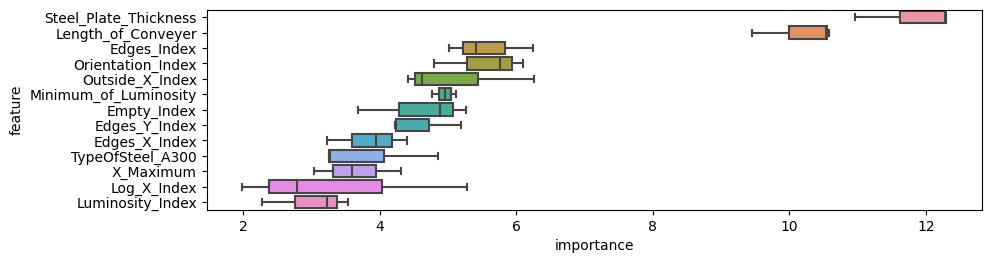

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    X,
    best_model = models,
    height = 0.20,
    top_n=13,
)

### Инференс теста - усредняем предсказания моделей

In [14]:
for n, model in enumerate(models):
    if n == 0:
        preds = model.predict_proba(test.drop(columns=['id']))[:, :-1]
    else:
        preds += model.predict_proba(test.drop(columns=['id']))[:, :-1]
preds = preds / n_splits
preds.shape

(12814, 7)

Измените, чтобы получился валидный файл для сабмишена

In [15]:
# подготовка файла для сабмишена
submission = pd.DataFrame(
    preds,
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.540375,0.006043,0.002168,0.000102,0.031781,0.124542,0.261535
1,19220,0.268060,0.023043,0.006226,0.000799,0.206832,0.106996,0.356959
2,19221,0.003453,0.040531,0.053033,0.001697,0.010711,0.291086,0.520316
3,19222,0.113590,0.003795,0.001653,0.003258,0.008865,0.361205,0.457261
4,19223,0.004055,0.002435,0.003376,0.005341,0.006246,0.641654,0.300659


# 3. Исходный датасет соревнования  (10 мин)
https://www.kaggle.com/datasets/kapturovalexander/steel-plates-faults-from-uci



* Возьмите оригинальный датасет, на базе которого сгенерированны данные соревнования
* Посмотрите соответствуют ли форматы датасетов друг другу, приведите их к одинаковой форме
* Сконкатенируйте оригинальный датасет с трейном, разбейте на выборки
* Обучите CatBoost, проверьте как изменился скор. 
* В худшую или в лучшую сторону? Попробуйте ответить почему.

### Сравним оригинальный датасет и трэйн
совпадают ли столбцы?

In [16]:
original = pd.read_csv('/kaggle/input/steel-plates-faults-from-uci/Steel Plates Faults.csv')
original

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.3662,0.3906,0.5714,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.2118,0.4554,0.5484,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.2132,0.3287,0.5172,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.2015,0.5904,0.9394,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


In [17]:
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6


### Посмотрим на таргеты трэйна и оригинала
Совпадают ли метки?

,Dirtiness,Stains,Pastry,Z_Scratch,K_Scatch,Bumps,Other_Faults,count
0,0,0,0,0,0,0,1,673
1,0,0,0,0,0,1,0,402
2,0,0,0,0,1,0,0,391
3,0,0,0,1,0,0,0,190
4,0,0,1,0,0,0,0,158
5,0,1,0,0,0,0,0,72
6,1,0,0,0,0,0,0,55


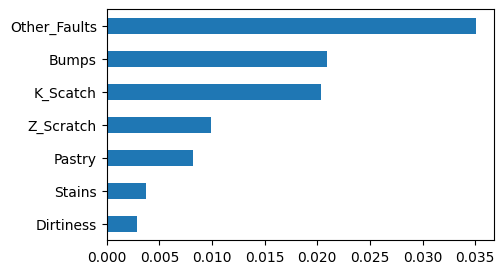

In [18]:
labels = (original[targets].sum() / train.shape[0]).sort_values()

fig, ax = plt.subplots(figsize=(5, 3))
labels.plot(kind='barh', ax=ax);

label_comb_counts = original[labels.index].value_counts().reset_index()
label_comb_counts.columns = labels.index.to_list() + ['count']
label_comb_counts

,Dirtiness,Stains,Z_Scratch,Pastry,K_Scatch,Bumps,Other_Faults,count
0,0,0,0,0,0,0,1,6540
1,0,0,0,0,0,1,0,4761
2,0,0,0,0,1,0,0,3411
3,0,0,0,1,0,0,0,1465
4,0,0,1,0,0,0,0,1150
5,0,0,0,0,0,0,0,818
6,0,1,0,0,0,0,0,568
7,1,0,0,0,0,0,0,485


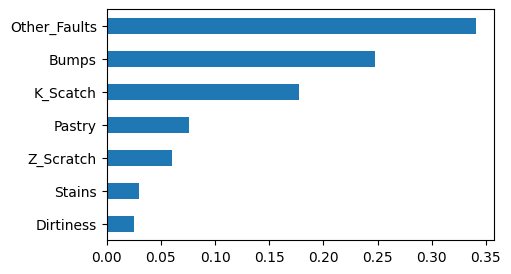

In [19]:
labels = (train[targets].sum() / train.shape[0]).sort_values()

fig, ax = plt.subplots(figsize=(5, 3))
labels.plot(kind='barh', ax=ax);

label_comb_counts = train[labels.index].value_counts().reset_index()
label_comb_counts.columns = labels.index.to_list() + ['count']
label_comb_counts

### Добавляем таргетный столбец в оригинал для мультикласс-задачи
Нужно ли что-то делать с метками или нет?

In [20]:
# добавляем столбец target
sparse_labels = original[targets].values.copy()
sparse_labels = np.concatenate([sparse_labels, 1 - sparse_labels.sum(1)[:, np.newaxis]], axis=1)
original['target'] = np.argmax(sparse_labels, axis=1)
original.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0,0


In [21]:
original.target.value_counts()

target
6    673
5    402
2    391
1    190
0    158
3     72
4     55
Name: count, dtype: int64

In [22]:
train.target.value_counts()

target
6    6540
5    4761
2    3411
0    1465
1    1150
7     818
3     568
4     485
Name: count, dtype: int64

In [23]:
# Сконкатенируйте новый трэйн, учитывая все расхождения в дтасетах
new_train = pd.concat((train.drop('id', axis=1), original)).reset_index(drop=True)
new_train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21134,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.3662,0.3906,0.5714,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1,6
21135,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.2118,0.4554,0.5484,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1,6
21136,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.2132,0.3287,0.5172,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1,6
21137,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.2015,0.5904,0.9394,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1,6


In [24]:
new_X = new_train.drop(columns=targets + ['target'])
new_y = new_train['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2,
                                                  random_state=43, stratify=new_y)

### Обучаем CatBoost

In [26]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.139919
0:	test: 0.8371755	best: 0.8371755 (0)	total: 10.6ms	remaining: 10.6s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9205036	best: 0.9205036 (50)	total: 487ms	remaining: 9.05s
100:	test: 0.9226038	best: 0.9226093 (99)	total: 959ms	remaining: 8.54s
150:	test: 0.9229763	best: 0.9231579 (135)	total: 1.43s	remaining: 8.04s
200:	test: 0.9236274	best: 0.9238614 (188)	total: 1.91s	remaining: 7.58s
250:	test: 0.9230142	best: 0.9238975 (204)	total: 2.38s	remaining: 7.12s
300:	test: 0.9228467	best: 0.9238975 (204)	total: 2.86s	remaining: 6.63s
bestTest = 0.9238975026
bestIteration = 204
Shrink model to first 205 iterations.
{'learn': {'MultiClass': 0.7436511599328839}, 'validation': {'AUC:type=Mu': 0.9238975025868958, 'MultiClass': 1.0093279272853595}}


In [27]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8720149392107998

# 5. Pseudolabeling (15 мин)
Откуда ещё можно взять данных? У нас же в доступе тестовый датасет и модель с точностью 0.86. <br>
Мы можем проинференсить моделью тест, получить метки, и добавить эти данные к трэйну! <br>
**ВАЖНО!!! Валидироваться только по данным из исходного трэйна.**

* Обучить CatBoost только на трэйне (без оригинала)
* Проинференсить тэст - получить таргеты
* Разбить трэйн на обучающую и валидационную части
* Приконкатить к обучающей части тэст
* Обучить CatBoost с новыми данными - проверить как изменился скор
* Улучшился ли скор? Как можно было бы на это повлиять?

### Обучаем CatBoost

In [29]:
X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

### Обучаем CatBoost

In [31]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.138564
0:	test: 0.8300504	best: 0.8300504 (0)	total: 11ms	remaining: 11s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9151371	best: 0.9151371 (50)	total: 480ms	remaining: 8.94s
100:	test: 0.9177750	best: 0.9178359 (99)	total: 942ms	remaining: 8.39s
150:	test: 0.9184430	best: 0.9187128 (147)	total: 1.4s	remaining: 7.88s
200:	test: 0.9183753	best: 0.9188861 (188)	total: 1.87s	remaining: 7.42s
250:	test: 0.9176954	best: 0.9188861 (188)	total: 2.35s	remaining: 7s
bestTest = 0.9188860994
bestIteration = 188
Shrink model to first 189 iterations.
{'learn': {'MultiClass': 0.7782957044984699}, 'validation': {'AUC:type=Mu': 0.9188860993644494, 'MultiClass': 1.0450368881225587}}


In [32]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8617488011137314

### Инференсим тест

In [33]:
# Предскажите тест, чтобы получить однозначную метку класса для теста
test['target'] = model.predict(test.drop('id', axis=1))
test.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,1656,0,1,150,0.3877,0.4896,0.3273,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172,0
1,19220,1257,1271,419960,419973,370,26,28,39293,92,132,1354,0,1,40,0.1629,0.4136,0.0938,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104,6
2,19221,1358,1372,117715,117724,289,36,32,29386,101,134,1360,0,1,40,0.0609,0.6234,0.4762,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514,6
3,19222,158,168,232415,232440,80,10,11,8586,107,140,1690,1,0,100,0.4439,0.3333,0.8182,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051,6
4,19223,559,592,544375,544389,140,19,15,15524,103,134,1688,1,0,60,0.8191,0.2619,0.4286,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170,5


### Конкатенируем тест к X_train

In [34]:
X_train = pd.concat((X_train, test.drop(['id', 'target'], axis=1)))
y_train = pd.concat((y_train, test['target']))

In [35]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.14732
0:	test: 0.8093118	best: 0.8093118 (0)	total: 11.6ms	remaining: 11.6s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9123500	best: 0.9123986 (49)	total: 501ms	remaining: 9.33s
100:	test: 0.9157466	best: 0.9157466 (100)	total: 987ms	remaining: 8.78s
150:	test: 0.9171097	best: 0.9171752 (138)	total: 1.45s	remaining: 8.16s
200:	test: 0.9168380	best: 0.9172345 (170)	total: 1.91s	remaining: 7.6s
250:	test: 0.9168249	best: 0.9172345 (170)	total: 2.39s	remaining: 7.14s
bestTest = 0.9172345332
bestIteration = 170
Shrink model to first 171 iterations.
{'learn': {'MultiClass': 0.6231456682388542}, 'validation': {'AUC:type=Mu': 0.9172345331738043, 'MultiClass': 1.1011690775553384}}


In [36]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8580181470741388

Почему скор упал? Как можно на это повлиять? Может быть параметр `sample_weight=` в методе `fit` натолкнёт на мысли?

Попробуйте провести эксперимент дома.

# 6. Adversarial validation. (20 мин)
[Короткая статья объясняющая смысл техники.](https://deepschool-pro.notion.site/Covariance-shift-Adversarial-validation-32fab6caa55e48eeb5dd2fbe4164378c)

Может указать нам 2 источника Covariance Shift:
* Признаки, которые влияют на сдвиг (можно их отсеить или дать им меньший вес)
* Сэмплы, которые влияют на сдвиг предсказания (можно на базе Advirsarial validation найти sample_weights)

* Проверить на Covariance shift следующие пары:
- трэйн и тэст
- оригинал и тэст

Алгоритм:
* Создаём новый столбец в каждом датасете - в тесте присваиваем ему 1, в другом 0
* Собираем датасеты в единый трэйн, делим на обучающий и валидациооный сэты
* Обучаем классификатор различать трэйн от теста (таргет=новый столбец)
* Чем AUC > 0.5,тем больше ковариационный сдвиг
* Инферинсим трэйн новым классификатором (лучше predict_proba) - предсказания будут весами для 'sample_weigts'
* Учим CatBoost под нашу задачу, учитывая сдвиг, передав веса сэмплов в метод fit.
* Не забываем удалить новый столбец из X
* Смотрим скор

In [37]:
train['new'] = 0
test['new'] = 1

adv_train = pd.concat((train.drop(["id", "target"] + targets, axis=1),
                       test.drop(["id", "target"], axis=1)))
adv_train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,new
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,1101,1116,447943,447992,313,32,37,21603,79,103,1353,0,1,70,0.2853,0.3050,0.2339,0.0126,0.4063,0.9194,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894,1
12810,1289,1306,3149494,3149542,59,9,18,5249,113,141,1362,0,1,40,0.0106,0.2778,0.2778,0.0052,0.7778,1.0000,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954,1
12811,41,210,1587535,1587191,16584,796,522,1858162,24,143,1400,0,1,40,0.0557,0.5644,0.9371,0.1236,0.2199,0.4097,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000,1
12812,1329,1340,702237,702267,386,43,34,36875,66,124,1364,0,1,40,0.0133,0.1814,0.1539,0.0095,0.2407,1.0000,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844,1


In [38]:
X = adv_train.drop(columns=['new'])
y = adv_train['new']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

### Обучаем CatBoost

In [40]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.054052


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.4926551	best: 0.4926551 (0)	total: 17.3s	remaining: 4h 48m 43s
50:	test: 0.4962000	best: 0.4963228 (46)	total: 19s	remaining: 5m 53s
100:	test: 0.4982452	best: 0.4997790 (77)	total: 21s	remaining: 3m 6s
150:	test: 0.4982047	best: 0.5002655 (126)	total: 22.8s	remaining: 2m 7s
200:	test: 0.4961473	best: 0.5002655 (126)	total: 24.5s	remaining: 1m 37s
bestTest = 0.5002655387
bestIteration = 126
Shrink model to first 127 iterations.
{'learn': {'Logloss': 0.6587507230124175}, 'validation': {'Logloss': 0.673503417587459, 'AUC': 0.5002655386924744}}


In [41]:
y_pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.5002653953700091

### Есть ли сдвиг? Какие причины?

## Проверяем тест и оригинал

In [42]:
original['new'] = 0
adv_train = pd.concat((original.drop(["target"] + targets, axis=1),
                       test.drop(["id", "target"], axis=1)))
adv_train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,new
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,1101,1116,447943,447992,313,32,37,21603,79,103,1353,0,1,70,0.2853,0.3050,0.2339,0.0126,0.4063,0.9194,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894,1
12810,1289,1306,3149494,3149542,59,9,18,5249,113,141,1362,0,1,40,0.0106,0.2778,0.2778,0.0052,0.7778,1.0000,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954,1
12811,41,210,1587535,1587191,16584,796,522,1858162,24,143,1400,0,1,40,0.0557,0.5644,0.9371,0.1236,0.2199,0.4097,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000,1
12812,1329,1340,702237,702267,386,43,34,36875,66,124,1364,0,1,40,0.0133,0.1814,0.1539,0.0095,0.2407,1.0000,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844,1


In [43]:
X = adv_train.drop(columns=['new'])
y = adv_train['new']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

### Обучаем CatBoost

In [45]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.05773
0:	test: 0.6043005	best: 0.6043005 (0)	total: 40.7ms	remaining: 40.7s


Default metric period is 5 because AUC is/are not implemented for GPU


50:	test: 0.6881473	best: 0.6883645 (49)	total: 1.61s	remaining: 29.9s
100:	test: 0.7099414	best: 0.7099998 (98)	total: 3.32s	remaining: 29.6s
150:	test: 0.7253018	best: 0.7256361 (148)	total: 4.98s	remaining: 28s
200:	test: 0.7339418	best: 0.7341841 (199)	total: 6.66s	remaining: 26.5s
250:	test: 0.7501187	best: 0.7501187 (250)	total: 8.34s	remaining: 24.9s
300:	test: 0.7535437	best: 0.7550199 (280)	total: 10.1s	remaining: 23.4s
350:	test: 0.7591066	best: 0.7591066 (350)	total: 11.7s	remaining: 21.6s
400:	test: 0.7658249	best: 0.7658249 (400)	total: 13.3s	remaining: 19.9s
450:	test: 0.7709423	best: 0.7709423 (450)	total: 15s	remaining: 18.3s
500:	test: 0.7748722	best: 0.7748722 (500)	total: 16.7s	remaining: 16.6s
550:	test: 0.7823849	best: 0.7823849 (550)	total: 18.4s	remaining: 15s
600:	test: 0.7839205	best: 0.7842956 (566)	total: 20s	remaining: 13.3s
650:	test: 0.7855937	best: 0.7857104 (648)	total: 21.6s	remaining: 11.6s
700:	test: 0.7870941	best: 0.7875245 (696)	total: 23.2s	remain

In [46]:
y_pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.7970021439115728

### А здесь? 

In [47]:
# смотрим важность признаков
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,X_Minimum,9.467907
1,Edges_Index,8.412607
2,Y_Maximum,6.072850
3,Y_Minimum,5.451058
4,Orientation_Index,4.830486
5,Edges_X_Index,4.625403
6,X_Maximum,4.621680
7,Length_of_Conveyer,4.537952
8,Sum_of_Luminosity,4.408163
9,Steel_Plate_Thickness,4.050463


In [48]:
train['weight'] = 1
original['weight'] = model.predict_proba(original.drop(["target"] + targets, axis=1))[:,1]
original.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target,new,weight
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0,0,0,0.647132
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0,0,0,0.876945
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0,0,0,0.799647
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0,0,0,0.687897
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0,0,0,0.457350


In [49]:
new_train = pd.concat((train.drop('id', axis=1), original)).reset_index(drop=True)
new_train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target,new,weight
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3,0,1.000000
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6,0,1.000000
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2,0,1.000000
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2,0,1.000000
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21134,249,277,325780,325796,273,54,22,35033,119,141,1360,0,1,40,0.3662,0.3906,0.5714,0.0206,0.5185,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1,6,0,0.691407
21135,144,175,340581,340598,287,44,24,34599,112,133,1360,0,1,40,0.2118,0.4554,0.5484,0.0228,0.7046,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1,6,0,0.700607
21136,145,174,386779,386794,292,40,22,37572,120,140,1360,0,1,40,0.2132,0.3287,0.5172,0.0213,0.7250,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1,6,0,0.618561
21137,137,170,422497,422528,419,97,47,52715,117,140,1360,0,1,40,0.2015,0.5904,0.9394,0.0243,0.3402,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1,6,0,0.525757


In [50]:
new_X = new_train.drop(columns=targets + ['target', 'new'])
new_y = new_train['target']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2,
                                                  random_state=43, stratify=new_y)

### Обучаем CatBoost

In [52]:
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train.drop('weight', axis=1), y_train, eval_set=(X_test.drop('weight', axis=1), y_test),
          verbose=50, early_stopping_rounds=100, 
          sample_weight=X_train['weight'].values)
print(model.get_best_score())

Learning rate set to 0.139919
0:	test: 0.8289456	best: 0.8289456 (0)	total: 11.4ms	remaining: 11.4s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9213086	best: 0.9213086 (50)	total: 501ms	remaining: 9.32s
100:	test: 0.9228405	best: 0.9234348 (73)	total: 981ms	remaining: 8.73s
150:	test: 0.9225808	best: 0.9234348 (73)	total: 1.47s	remaining: 8.26s
bestTest = 0.9234348258
bestIteration = 73
Shrink model to first 74 iterations.
{'learn': {'MultiClass': 0.8504710119377185}, 'validation': {'AUC:type=Mu': 0.9234348258292121, 'MultiClass': 1.01013056557474}}


In [53]:
y_pred = model.predict_proba(X_test.drop('weight', axis=1))
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8731791546033774

# Дополнительные эксперименты
* Попробовать на задаче мультилэйбл
* Попробовать добавить оригинальный датасет в CV и увеличить количество фолдов до 5, 10
* Псевдолейблинг с пониженными весами для тэста